In [1]:
from sympy import simplify, parse_expr
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from flash_ansr import SkeletonPool, ExpressionSpace, get_path
from flash_ansr.expressions.utils import num_to_constants, numbers_to_num
from flash_ansr.eval.utils import bootstrapped_metric_ci
import time
import pickle

In [2]:
READ = True

In [3]:
pool = SkeletonPool.from_config(get_path('configs', 'v7.0', 'skeleton_pool_val.yaml'))
pool.sample_strategy['max_operators'] = 15
pool.sample_strategy['max_length'] = 2 * 15 + 1
pool.sample_strategy['max_tries'] = 100
pool.simplify = False

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 30004.54it/s]


In [4]:
auto_flash_space = ExpressionSpace.from_config(get_path('configs', 'v7.20', 'expression_space.yaml'))

In [5]:
N_SAMPLES = 10_000

In [6]:
import signal

def timeout_handler(signum, frame):
    raise TimeoutError()

signal.signal(signal.SIGALRM, timeout_handler)

def timeout(seconds, action=None):
    
    def decorator(func):
        
        def wraps(*args, **kwargs):
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            except TimeoutError:
                if hasattr(action, '__call__'):
                    result = action()
                else:
                    result = action
            signal.alarm(0)
            return result

        return wraps
    
    return decorator

@timeout(1, action=None)
def timeoutable_simplify(expr, ratio=None):
    if ratio is not None:
        return simplify(expr, ratio=ratio)
    return simplify(expr)

In [7]:
def sympy_simplify_wrapper(expression: list[str], ratio=None, debug=False):
    expression, constants = num_to_constants(list(expression))
    if debug: print(expression)

    expression = pool.expression_space.prefix_to_infix(expression, power='**')
    if debug: print(expression)

    for c in constants:
        expression = expression.replace(c, str(np.random.uniform(-10, 10)))
    if debug: print(expression)

    expression = parse_expr(expression)
    if debug: print(expression)

    if debug: print('Simplifying...')
    expression = timeoutable_simplify(expression, ratio)
    if expression is None:
        return None
    else:
        expression = str(expression)
    if debug: print(expression)

    translations = {
        'Abs': 'abs',
    }

    for translate_from, translate_to in translations.items():
        expression = expression.replace(translate_from, translate_to)

    if debug: print(f'Parsing {expression}')
    expression = pool.expression_space.parse_expression(expression)
    if debug: print(expression)

    expression = numbers_to_num(expression)
    if debug: print(expression)

    return tuple(expression)

In [8]:
if READ:
    with open(get_path('results', 'simplification', filename='simplification_results_w_auto.pkl'), 'rb') as f:
        simplified_skeletons = pickle.load(f)

    with open(get_path('results', 'simplification', filename='simplification_times_w_auto.pkl'), 'rb') as f:
        simplification_times = pickle.load(f)
else:
    simplified_skeletons = {}
    simplification_times = {}

    pbar = tqdm(total=N_SAMPLES, smoothing=0)
    while len(simplified_skeletons) < N_SAMPLES:
        skeleton, _, _ = pool.sample_skeleton()

        if skeleton in simplified_skeletons:
            continue
        pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

        try:
            custom_time1 = time.time()
            custom_simplified = pool.expression_space.simplify(skeleton)
            custom_time2 = time.time()
            
            auto_time1 = time.time()
            auto_simplified = auto_flash_space.simplify(skeleton)
            auto_time2 = time.time()

            sympy_time1 = time.time()
            sympy_simplified = sympy_simplify_wrapper(skeleton)
            sympy_time2 = time.time()

            sympy_1_time1 = time.time()
            sympy_1_simplified = sympy_simplify_wrapper(skeleton, ratio=1)
            sympy_1_time2 = time.time()

            simplified_skeletons[skeleton] = {
                'custom': custom_simplified,
                'auto': auto_simplified,
                'sympy': sympy_simplified,
                'sympy_1': sympy_1_simplified,
            }
            simplification_times[skeleton] = {
                'custom': custom_time2 - custom_time1,
                'auto': auto_time2 - auto_time1,
                'sympy': sympy_time2 - sympy_time1,
                'sympy_1': sympy_1_time2 - sympy_1_time1,
            }

        except (IndexError, ValueError, KeyError, RecursionError):
            continue

        pbar.update(1)

    pbar.close()

    with open(get_path('results', 'simplification', filename='simplification_results_w_auto.pkl'), 'wb') as f:
        pickle.dump(simplified_skeletons, f)

    with open(get_path('results', 'simplification', filename='simplification_times_w_auto.pkl'), 'wb') as f:
        pickle.dump(simplification_times, f)

In [9]:
# Extract the most common n-grams for raw and each simplified version
# Create a dictionary like ngrams['raw' | 'custom' | 'sympy' | 'sympy_1'][n] = {n-gram: count}
ngrams = {'raw': {}, 'auto': {}, 'custom': {}, 'sympy': {}, 'sympy_1': {}}
max_n = 5

for skeleton, simplified in simplified_skeletons.items():
    for key, value in simplified.items():
        if value is None:
            continue
        for n in range(1, max_n):
            for i in range(len(value) - n + 1):
                ngram = tuple(value[i:i + n])
                if n not in ngrams[key]:
                    ngrams[key][n] = {}
                if ngram not in ngrams[key][n]:
                    ngrams[key][n][ngram] = 0
                ngrams[key][n][ngram] += 1

                
for skeleton, simplified in simplified_skeletons.items():
    if skeleton is None:
        continue
    for n in range(1, max_n):
        for i in range(len(skeleton) - n + 1):
            ngram = tuple(skeleton[i:i + n])
            if n not in ngrams['raw']:
                ngrams['raw'][n] = {}
            if ngram not in ngrams['raw'][n]:
                ngrams['raw'][n][ngram] = 0
            ngrams['raw'][n][ngram] += 1

# Sort the n-grams by count
for key in ngrams.keys():
    for n in ngrams[key].keys():
        ngrams[key][n] = dict(sorted(ngrams[key][n].items(), key=lambda x: x[1], reverse=True))

In [10]:
method_alias = {'raw': 'Raw', 'raw': 'Auto', 'custom': 'ANSR', 'sympy': 'SymPy', 'sympy_1': 'SymPy (r=1)'}

# Examples

In [11]:
id = 29
raw = tuple(str(t) for t in list(simplified_skeletons.keys())[id])
print(raw, len(raw))
for k, v in simplified_skeletons[raw].items():
    print(f'{k:<10}', tuple(str(t) for t in v), len(v))

print()
print(pool.expression_space.prefix_to_infix(raw))
for k, v in simplified_skeletons[raw].items():
    if v is not None:
        print(f'{k:<10}', pool.expression_space.prefix_to_infix(v))

('*', '*', 'tan', 'abs', 'x1', '+', 'x2', '/', 'tan', '-', '<num>', 'log', '*', 'x1', 'exp', '*', 'x3', 'x3', '<num>', '<num>') 20
custom     ('*', '<num>', '*', 'tan', 'abs', 'x1', '+', 'x2', '/', 'tan', '-', '<num>', 'log', '*', 'x1', 'exp', 'pow2', 'x3', '<num>') 19
auto       ('*', '<num>', '*', 'tan', 'abs', 'x1', '+', 'x2', '/', 'tan', '-', '<num>', 'log', '*', 'x1', 'exp', 'pow2', 'x3', '<num>') 19
sympy      ('*', '+', '*', '<num>', 'x2', '*', '<num>', 'tan', '-', 'log', '*', 'x1', 'exp', 'pow2', 'x3', '<num>', 'tan', 'abs', 'x1') 19
sympy_1    ('*', '<num>', '*', '-', 'x2', '*', '<num>', 'tan', '+', 'log', '*', 'x1', 'exp', 'pow2', 'x3', '<num>', 'tan', 'abs', 'x1') 19

(tan(abs(x1)) * (x2 + (tan(<num> - log(x1 * exp(x3 * x3))) / <num>))) * <num>
custom     <num> * (tan(abs(x1)) * (x2 + (tan(<num> - log(x1 * exp(pow2(x3)))) / <num>)))
auto       <num> * (tan(abs(x1)) * (x2 + (tan(<num> - log(x1 * exp(pow2(x3)))) / <num>)))
sympy      ((<num> * x2) + (<num> * tan(log(x1 * exp(p

# Length

In [12]:
min_length, max_length = np.inf, -np.inf
for k, v in simplified_skeletons.items():
    min_length = np.min([min_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])
    max_length = np.max([max_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])

/tmp/ipykernel_7327/1714029307.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=-8)


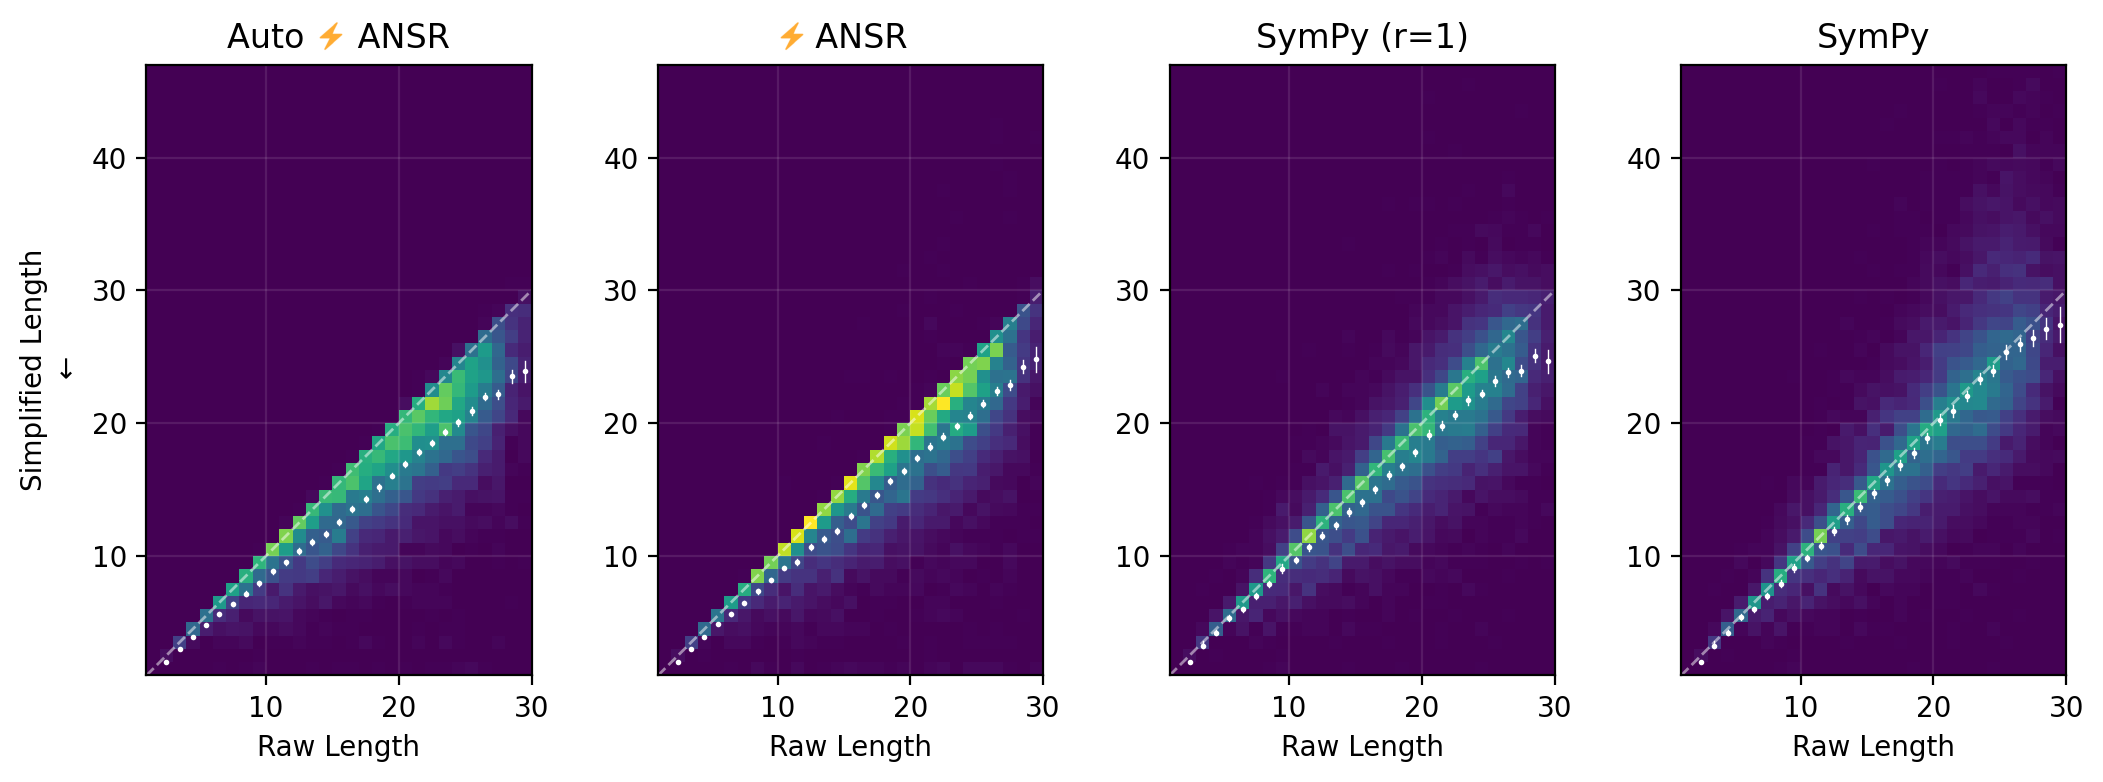

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), dpi=200)

raw_bins = np.arange(min_length, 31)
simplified_bins = np.arange(min_length, 48)

vmin, vmax = np.inf, -np.inf

for method in ['auto', 'custom', 'sympy_1', 'sympy']:
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)
    h = np.histogram2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins]);
    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method, name in zip(axes, ['auto','custom', 'sympy_1', 'sympy'], ['Auto     ANSR', '  ANSR', 'SymPy (r=1)', 'SymPy']):
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)

    ax.hist2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins], cmap='viridis', vmin=vmin, vmax=vmax, linewidth=0, rasterized=True);
    ax.set_xlabel('Raw Length')
    if method == 'auto':
        ax.set_ylabel(f'Simplified Length\n$\\leftarrow$')
    ax.set_title(name)
    ax.grid(color='white', alpha=0.1)
    # ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(np.arange(0, max_length + 1, 10))
    ax.set_yticks(np.arange(0, max_length + 1, 10))

    ax.set_facecolor(plt.get_cmap('viridis')(0))

    ax.set_xlim(*raw_bins[[0, -1]])
    ax.set_ylim(*simplified_bins[[0, -1]])

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Draw a line that shows the median simplified length for each raw length
    x_list = []
    y_list = []
    y_upper_list = []
    y_lower_list = []
    for i in range(len(raw_bins) - 1):
        raw_mask = (original_lengths >= raw_bins[i]) & (original_lengths < raw_bins[i + 1])
        if np.any(raw_mask):
            statistic, lower, upper = bootstrapped_metric_ci(simplified_lengths[raw_mask], np.nanmean)
            x_list.append((raw_bins[i] + raw_bins[i + 1]) / 2)
            y_list.append(statistic)
            y_upper_list.append(upper)
            y_lower_list.append(lower)
    ax.scatter(x_list, y_list, color='w', s=1)
    for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
        ax.plot([x, x], [y_lower, y_upper], color='w', lw=0.5)
    # Draw a diagonal
    ax.plot([1, max_length], [1, max_length], color='white', lw=1, ls='--', alpha=0.5)

# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.357, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

ax_image = fig.add_axes([0.165, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

fig.tight_layout(w_pad=-8)
plt.savefig(get_path('results', 'simplification', filename='length_custom_vs_sympy_10k_unique_w_auto.svg', create=True), bbox_inches='tight')

Custom: 0.91
Sympy: 1.00


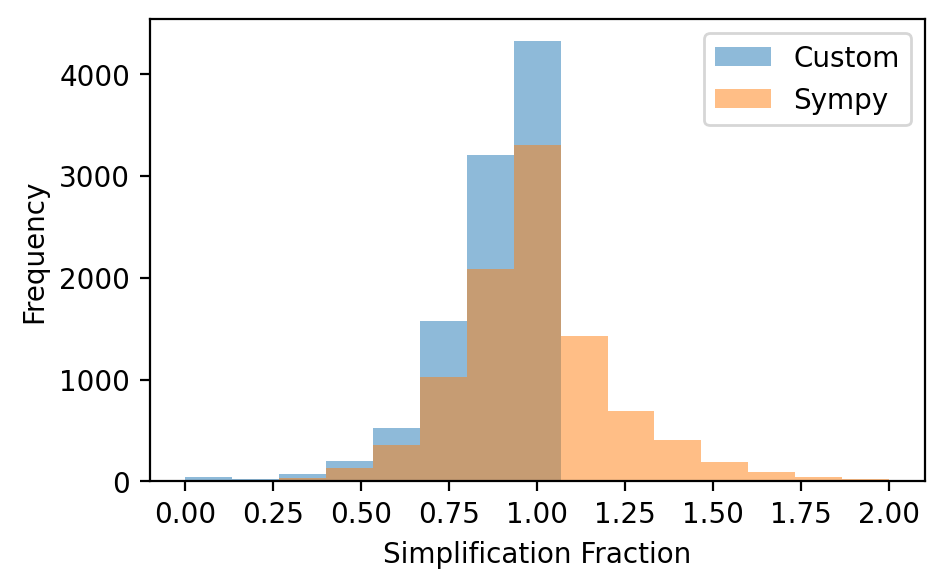

In [14]:
# Compute the average simplification fraction (simplified length / original length)
simplification_fractions = {}
for k, v in simplified_skeletons.items():
    simplification_fractions[k] = {
        'custom': len(v['custom']) / len(k) if v['custom'] is not None else np.inf,
        'sympy': len(v['sympy']) / len(k) if v['sympy'] is not None else np.inf,
    }

# Average simplification fraction
custom_fractions = np.array([v['custom'] for v in simplification_fractions.values()])
sympy_fractions = np.array([v['sympy'] for v in simplification_fractions.values()])
custom_mean, sympy_mean = np.median(custom_fractions), np.median(sympy_fractions)

print(f'Custom: {custom_mean:.2f}')
print(f'Sympy: {sympy_mean:.2f}')

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

bins = np.linspace(0, 2, 16)

ax.hist(custom_fractions, bins=bins, alpha=0.5, label='Custom', color='tab:blue');
ax.hist(sympy_fractions, bins=bins, alpha=0.5, label='Sympy', color='tab:orange');
ax.set_xlabel('Simplification Fraction')
ax.set_ylabel('Frequency')
ax.legend();
plt.savefig(get_path('results', 'simplification', filename='simplification_fraction_custom_vs_sympy_10k_unique.svg', create=True))

# Depth

In [15]:
def is_leaf(token):
    return token in ['x1', 'x2', 'x3', '<num>']

def depth(expression):
    """
    Compute the depth of an expression tree given in prefix notation.
    Args:
        expression: List of tokens representing the tree
        is_leaf: Function that returns True if a token is a leaf node
    Returns:
        The depth of the tree (0 for empty tree, 1 for single node)
    """
    if not expression:
        return 0
        
    def process_node(pos):
        """
        Process a node starting at position pos.
        Returns: (subtree_depth, tokens_processed)
        """
        if pos >= len(expression):
            return 0, 0
            
        if is_leaf(expression[pos]):
            return 1, 1
            
        # For non-leaf nodes, process children
        max_child_depth = 0
        total_processed = 1  # Count current node
        curr_pos = pos + 1
        
        # Process both children if we have enough tokens
        while curr_pos < len(expression) and total_processed < 3:
            child_depth, tokens = process_node(curr_pos)
            max_child_depth = max(max_child_depth, child_depth)
            curr_pos += tokens
            total_processed += tokens
            
        return max_child_depth + 1, total_processed
    
    max_depth, _ = process_node(0)
    return max_depth

In [16]:
min_depth, max_depth = np.inf, -np.inf
for k, v in simplified_skeletons.items():
    min_depth = np.min([min_depth, depth(k)] + [len(vi) for vi in v.values() if vi is not None])
    max_depth = np.max([max_depth, depth(k)] + [len(vi) for vi in v.values() if vi is not None])

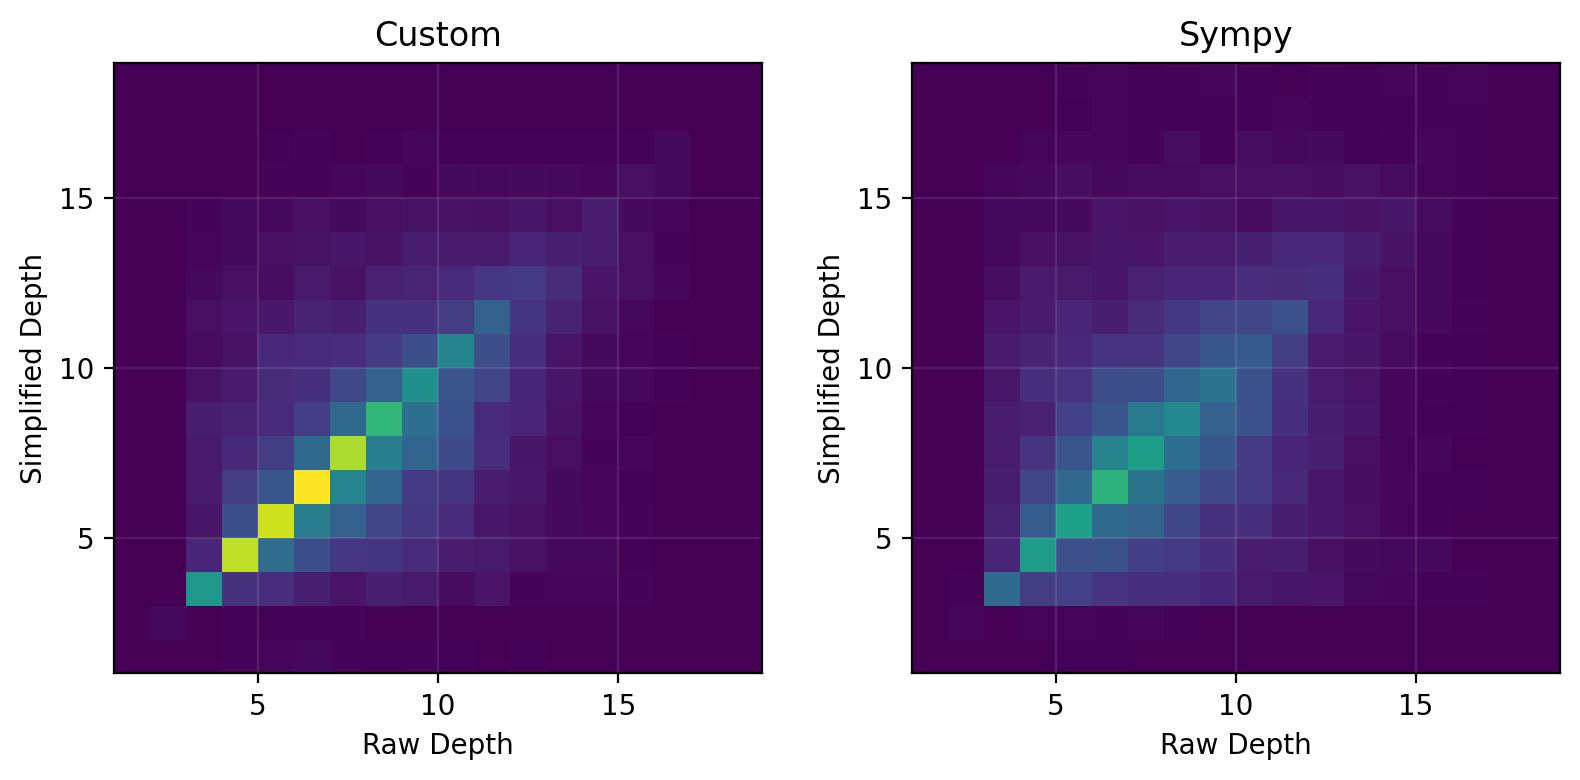

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200)

raw_bins = np.arange(min_depth, 20)
simplified_bins = np.arange(min_depth, 20)

vmin, vmax = np.inf, -np.inf

for method in ['custom', 'sympy']:
    original_depths = np.array([depth(k) for k in simplified_skeletons.keys()])
    simplified_depths = np.array([np.nan if v[method] is None else depth(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_depths)
    h = np.histogram2d(original_depths[valid_mask], simplified_depths[valid_mask], bins=[raw_bins, simplified_bins]);
    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method in zip(axes, ['custom', 'sympy']):
    original_depths = np.array([depth(k) for k in simplified_skeletons.keys()])
    simplified_depths = np.array([np.nan if v[method] is None else depth(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_depths)

    ax.hist2d(original_depths[valid_mask], simplified_depths[valid_mask], bins=[raw_bins, simplified_bins], cmap='viridis', vmin=vmin, vmax=vmax);
    ax.set_xlabel('Raw Depth')
    ax.set_ylabel(f'Simplified Depth')
    ax.set_title(f'{method.capitalize()}')
    ax.grid(color='white', alpha=0.1)
    # ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(np.arange(0, max_depth + 1, 5))
    ax.set_yticks(np.arange(0, max_depth + 1, 5))

    ax.set_facecolor(plt.get_cmap('viridis')(0))

    ax.set_xlim(*raw_bins[[0, -1]])
    ax.set_ylim(*simplified_bins[[0, -1]])

fig.tight_layout(w_pad=2)
plt.savefig(get_path('results', 'simplification', filename='depth_custom_vs_sympy_10k_unique.svg', create=True))

# Time

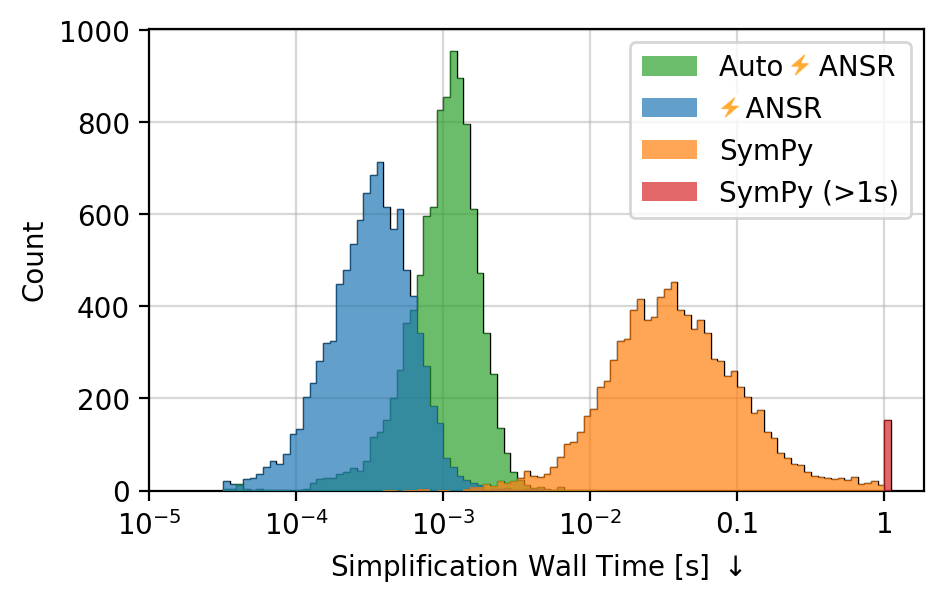

In [18]:
# Show simplification times
auto_times = np.array([v['auto'] for v in simplification_times.values()])
custom_times = np.array([v['custom'] for v in simplification_times.values()])
sympy_times = np.array([v['sympy'] for v in simplification_times.values()])
sympy_valid_mask = ~np.array([simplified_skeletons[k]['sympy'] is None for k in simplification_times.keys()])

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

bins=np.linspace(-4.5, 0, 100)

ax.hist(np.log10(auto_times), bins=bins, alpha=0.7, label='Auto    ANSR', color='tab:green', zorder=3, linewidth=0, rasterized=True);
ax.hist(np.log10(custom_times), bins=bins, alpha=0.7, label='   ANSR', color='tab:blue', zorder=3, linewidth=0, rasterized=True);
ax.hist(np.log10(sympy_times), bins=bins, alpha=0.7, label='SymPy', color='tab:orange', zorder=3, linewidth=0, rasterized=True);

# Same thing but only outline
ax.hist(np.log10(auto_times), bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)
ax.hist(np.log10(custom_times), bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)
ax.hist(np.log10(sympy_times), bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

# Draw an extra bar showing the sum of the invalid samples. The bar should be red
width = bins[1] - bins[0]
ax.bar(width / 2, np.sum(~sympy_valid_mask), width=width, color='tab:red', alpha=0.7, lw=0.5, label='SymPy (>1s)', zorder=3, rasterized=True);
ax.bar(width / 2, np.sum(~sympy_valid_mask), width=width, lw=0.5, color='#00000000', edgecolor='k', zorder=2);


# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.745, 0.80, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

ax_image = fig.add_axes([0.675, 0.73, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')


ax.set_xticks(np.arange(-5, 1))
labels = [f'$10^{{{i}}}$' for i in np.arange(-5, 1)]
labels[-2] = '0.1'
labels[-1] = '1'
ax.set_xticklabels(labels)

ax.set_xlabel('Simplification Wall Time [s] $ \\downarrow $')
ax.set_ylabel('Count')
ax.legend();
ax.grid(alpha=0.5, zorder=0)
plt.savefig(get_path('results', 'simplification', filename='simplification_times_custom_vs_sympy_10k_unique_w_auto.svg', create=True), bbox_inches='tight')

In [19]:
np.mean(sympy_times) / np.mean(custom_times)

np.float64(415.84404152890636)

In [20]:
np.mean(sympy_times) / np.mean(auto_times) 

np.float64(141.68273956562894)

/tmp/ipykernel_31689/2343178673.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=2)


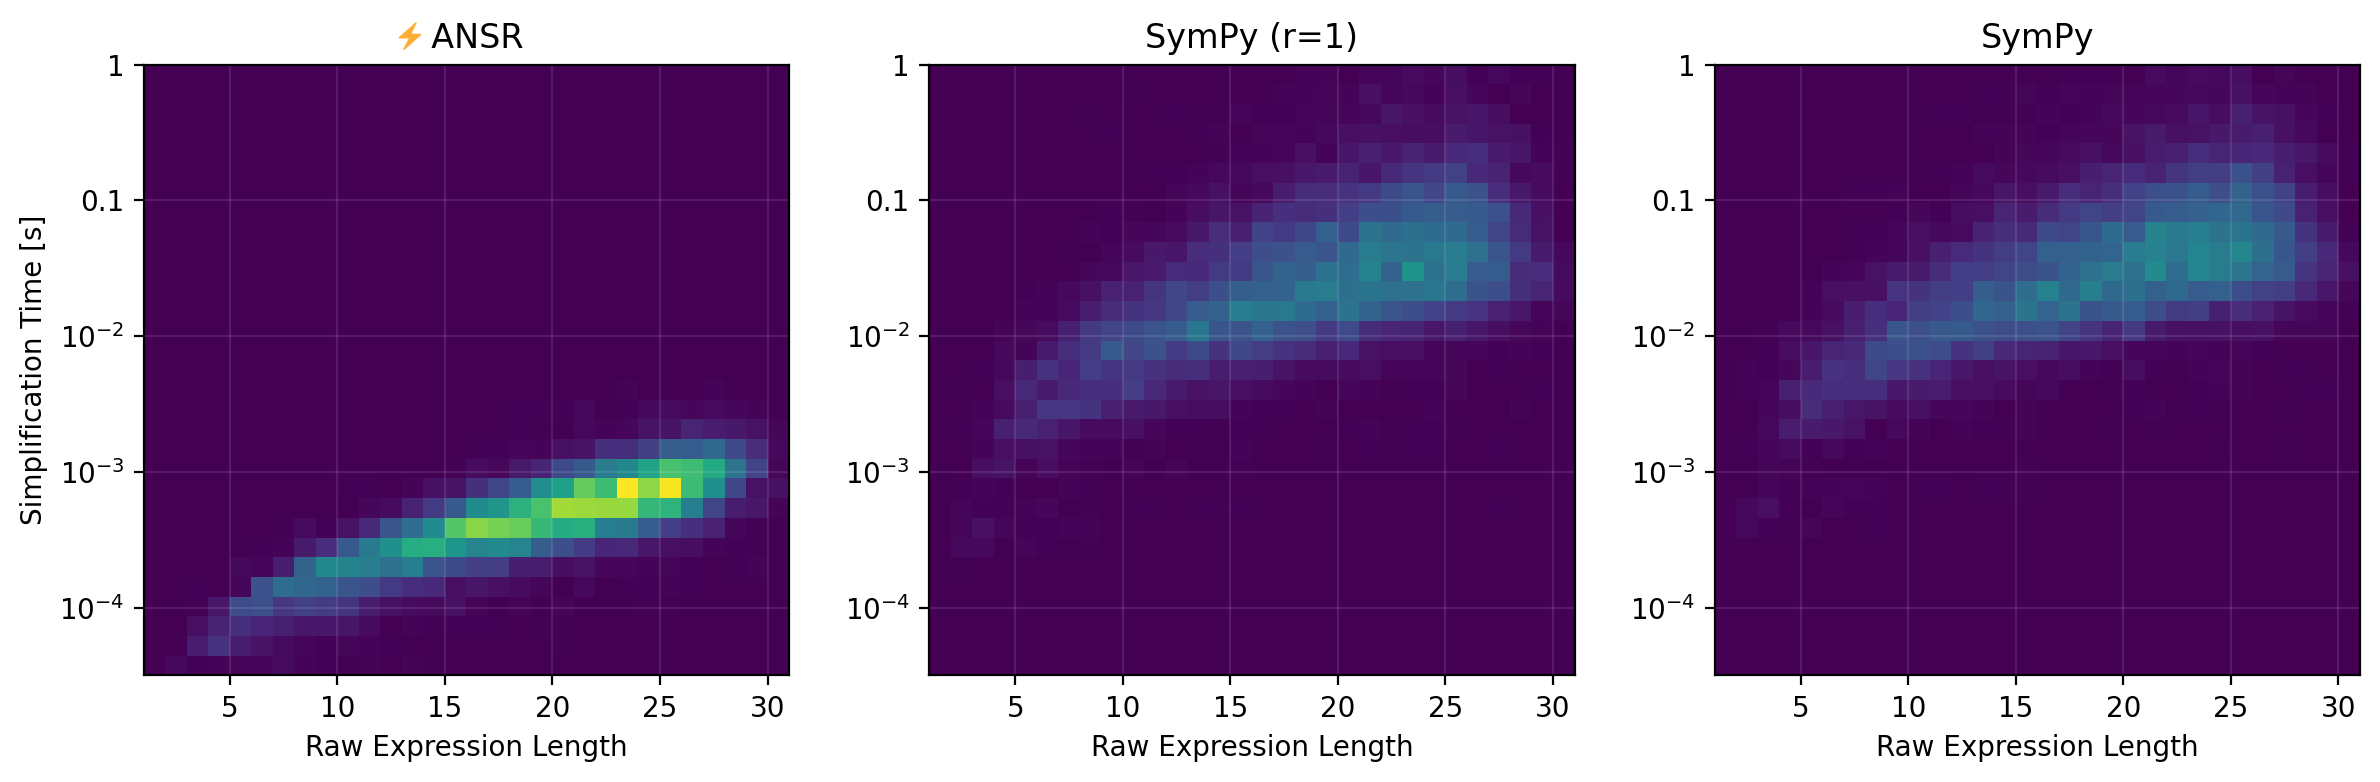

In [19]:
# 2d Histogram of the simplification times against the expression length
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=200)

time_bins = [np.linspace(-4.5, 0, 32), np.linspace(-4.5, 0, 32), np.linspace(-4.5, 0, 32)]
length_bins = np.arange(min_length, 32)

vmin, vmax = np.inf, -np.inf

for ax, method, time_bins_i in zip(axes, ['custom', 'sympy_1', 'sympy'], time_bins):
    times = np.array([v[method] for v in simplification_times.values()])
    lengths = np.array([len(k) for k in simplification_times.keys()])

    h = np.histogram2d(lengths, np.log10(times), bins=[length_bins, time_bins_i]);

    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method, time_bins_i, name in zip(axes, ['custom', 'sympy_1', 'sympy'], time_bins, ['  ANSR', 'SymPy (r=1)', 'SymPy']):
    times = np.array([v[method] for v in simplification_times.values()])
    lengths = np.array([len(k) for k in simplification_times.keys()])

    ax.hist2d(lengths, np.log10(times), bins=[length_bins, time_bins_i], cmap='viridis', vmin=vmin, vmax=vmax);
    ax.set_xlabel('Raw Expression Length')
    ax.set_title(name)
    ax.grid(color='white', alpha=0.1)

    ax.set_yticks(np.arange(-5, 1))
    labels = [f'$10^{{{i}}}$' for i in np.arange(-5, 1)]
    labels[-2] = '0.1'
    labels[-1] = '1'
    ax.set_yticklabels(labels)

    ax.set_ylim(*time_bins_i[[0, -1]])

    ax.set_facecolor(plt.get_cmap('viridis')(0))

axes[0].set_ylabel('Simplification Time [s]')

# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.14, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

fig.tight_layout(w_pad=2)
plt.savefig(get_path('results', 'simplification', filename='time_vs_length_custom_vs_sympy_10k_unique.svg', create=True))

# Operator Distributions

In [20]:
from collections import Counter

raw_counter = Counter()
custom_simplify_counter = Counter()
sympy_simplify_counter = Counter()
total_counter = Counter()

for k, v in simplified_skeletons.items():
    raw_counter.update(k)
    total_counter.update(k)

    if v['custom'] is not None:
        custom_simplify_counter.update(v['custom'])
        total_counter.update(v['custom'])

    if v['sympy_1'] is not None:
        sympy_simplify_counter.update(v['sympy_1'])
        total_counter.update(v['sympy_1'])

In [21]:
raw_key_to_id = {k: i for i, (k, _) in enumerate(raw_counter.most_common())}
total_key_to_id = {k: i for i, (k, _) in enumerate(total_counter.most_common())}

In [22]:
def int_to_k(i):
    if i < 1_000:
        return str(int(i))
    elif i < 1_000_000:
        return f'{int(i // 1_000)}k'
    else:
        return f'{int(i // 1_000_000)}M'

/tmp/ipykernel_31689/2213715523.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=2)


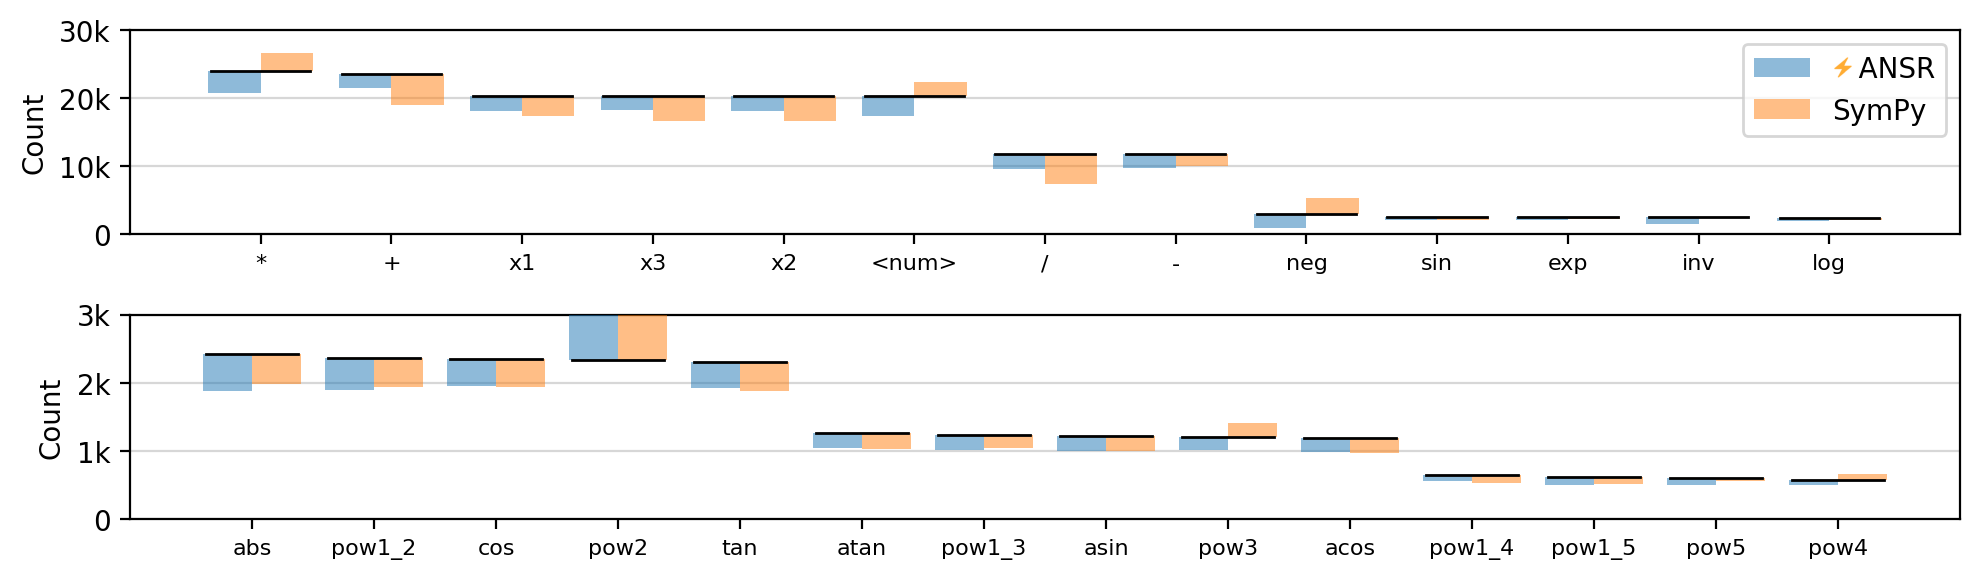

In [23]:
# Show a histogram of the occurences of each operator in the raw and simplified expressions (and a delta)
fig, axes = plt.subplots(2, 1, figsize=(10, 3), dpi=200)

offset_magnitude = 0.2
width = 0.4
epsilon = 0.02

mid = len(raw_counter) // 2
for ax, bounds, ylim in zip(axes, [(0, mid), (mid, len(raw_counter))], [3e4, 3e3]):
    for i, (_, v) in enumerate(raw_counter.most_common()[bounds[0]:bounds[1]]):
        ax.plot([i - offset_magnitude - width / 2 + epsilon, i + offset_magnitude + width / 2 - epsilon], [v, v], color='k', lw=1, zorder=4)
        
    for counter, title, offset_sign in zip([custom_simplify_counter, sympy_simplify_counter], ['   ANSR', 'SymPy'], [-1, 1]):
        raw_counts = np.array([v for _, v in raw_counter.most_common()[bounds[0]:bounds[1]]])
        simplified_counts = np.array([counter[k] for k, _ in raw_counter.most_common()[bounds[0]:bounds[1]]])

        offset = offset_magnitude * offset_sign

        ax.bar(np.arange(len(raw_counts)) + offset, simplified_counts - raw_counts, alpha=0.5, zorder=3, bottom=raw_counts, label=title, width=width)

    ax.set_ylabel('Count')

    ax.set_xticks(np.arange(bounds[1] - bounds[0]))
    ax.set_xticklabels([k for k, _ in raw_counter.most_common()[bounds[0]:bounds[1]]], fontsize=8)

    ax.set_xlim(-1, bounds[1] - bounds[0])
    ax.set_ylim(0, ylim)

    ax.set_yticks(np.linspace(0, ylim, 4))
    ax.set_yticklabels([int_to_k(i) for i in np.linspace(0, ylim, 4)])

    ax.grid(alpha=0.5, axis='y')
    
axes[0].legend()
# axes[0].set_title('Changes in Operator Distribution')

# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.891, 0.85, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')


fig.tight_layout(w_pad=2)
plt.savefig(get_path('results', 'simplification', filename='operator_changes_custom_vs_sympy_10k_unique.svg', create=True))

/tmp/ipykernel_31689/384236043.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


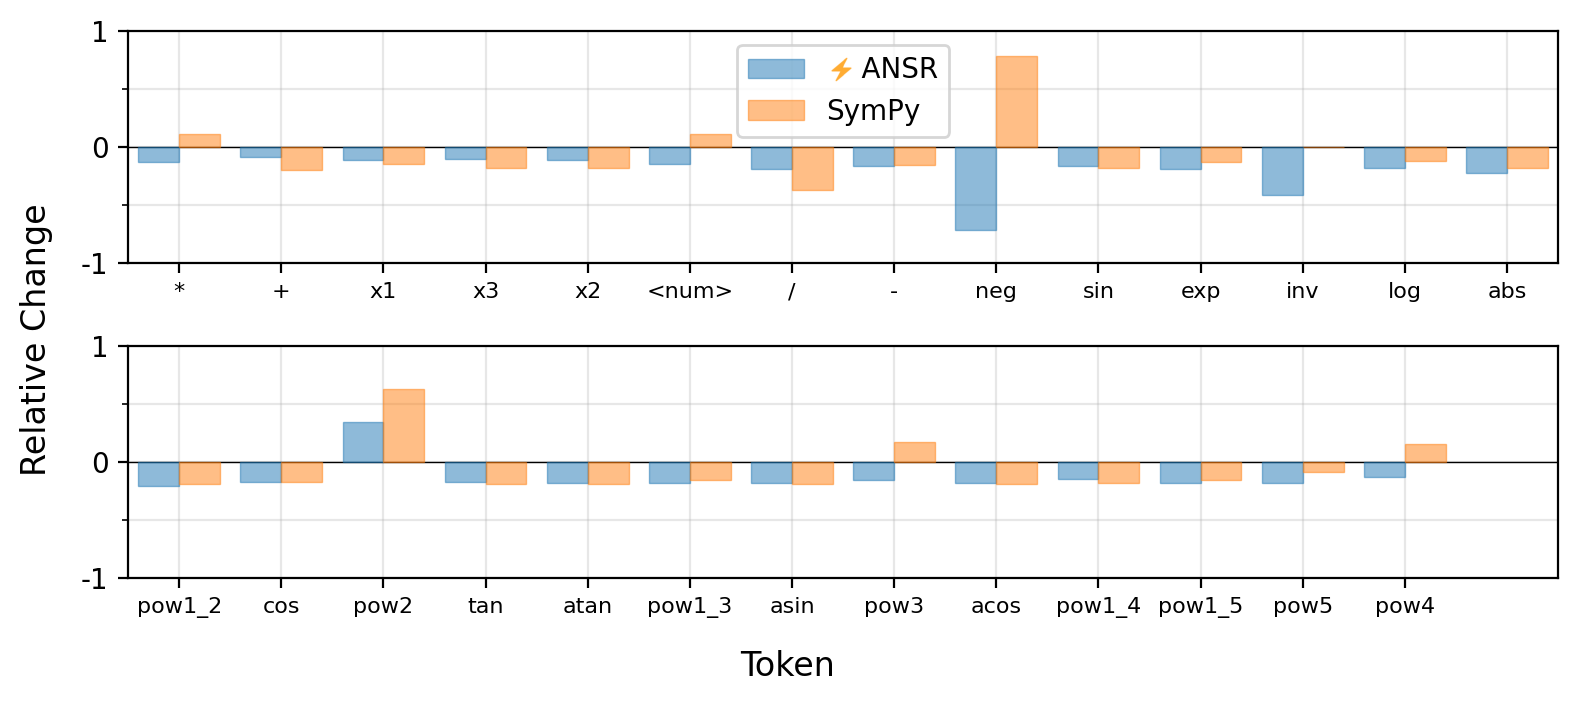

In [24]:
# For each operator, show the relative change in count
fig, axes = plt.subplots(2, 1, figsize=(8, 3.5), dpi=200)

n_per_plot = np.ceil(len(custom_simplify_counter) / 2).astype(int)

for i, ax in enumerate(axes):
    for j, counter, title, offset_sign in zip([0, 1], [custom_simplify_counter, sympy_simplify_counter], ['    ANSR', 'SymPy'], [-1, 1]):
        raw_counts = np.array([v for _, v in raw_counter.most_common()])[i * n_per_plot: (i + 1) * n_per_plot]
        simplified_counts = np.array([counter[k] for k, _ in raw_counter.most_common()])[i * n_per_plot: (i + 1) * n_per_plot]

        offset = offset_magnitude * offset_sign

        ax.bar(np.arange(len(raw_counts)) + offset, (simplified_counts - raw_counts) / raw_counts, alpha=0.5, zorder=3, label=title, width=width, edgecolor=f'C{j}', linewidth=0.5)

    ax.axhline(0, color='k', lw=0.5)

    # ax.set_title('Relative Changes in Operator Counts')
    ax.set_ylim(-1, 1)
    ax.grid(alpha=0.3, which='both')

    ax.set_xlim(-0.5, n_per_plot - 0.5)
    ax.set_xticks(np.arange(len(raw_counts)))
    ax.set_xticklabels([k for k, _ in raw_counter.most_common()][i * n_per_plot: (i + 1) * n_per_plot], fontsize=8)

    ax.set_yticks(np.linspace(-1, 1, 3))
    ax.set_yticklabels([-1, 0, 1])

    # Set minor ticks
    ax.set_yticks(np.linspace(-1, 1, 5), minor=True)

    
# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.5, 0.867, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

# axes[0].set_ylabel('Relative Change')
fig.supylabel('Relative Change')
fig.supxlabel('Token')
axes[0].legend(loc='upper center')

fig.tight_layout()
fig.subplots_adjust(bottom=0.16)

In [25]:
transition_matrices = {
    'custom': np.zeros((len(total_counter), len(total_counter))),
    'sympy_1': np.zeros((len(total_counter), len(total_counter))),
}

for raw_skeleton, s_skeletons in simplified_skeletons.items():
    for method in ['custom', 'sympy_1']:
        for token in raw_skeleton:
            if s_skeletons[method] is None:
                continue
            for simplified_token in s_skeletons[method]:
                transition_matrices[method][total_key_to_id[token], total_key_to_id[simplified_token]] += 1

In [26]:
from matplotlib.colors import LogNorm

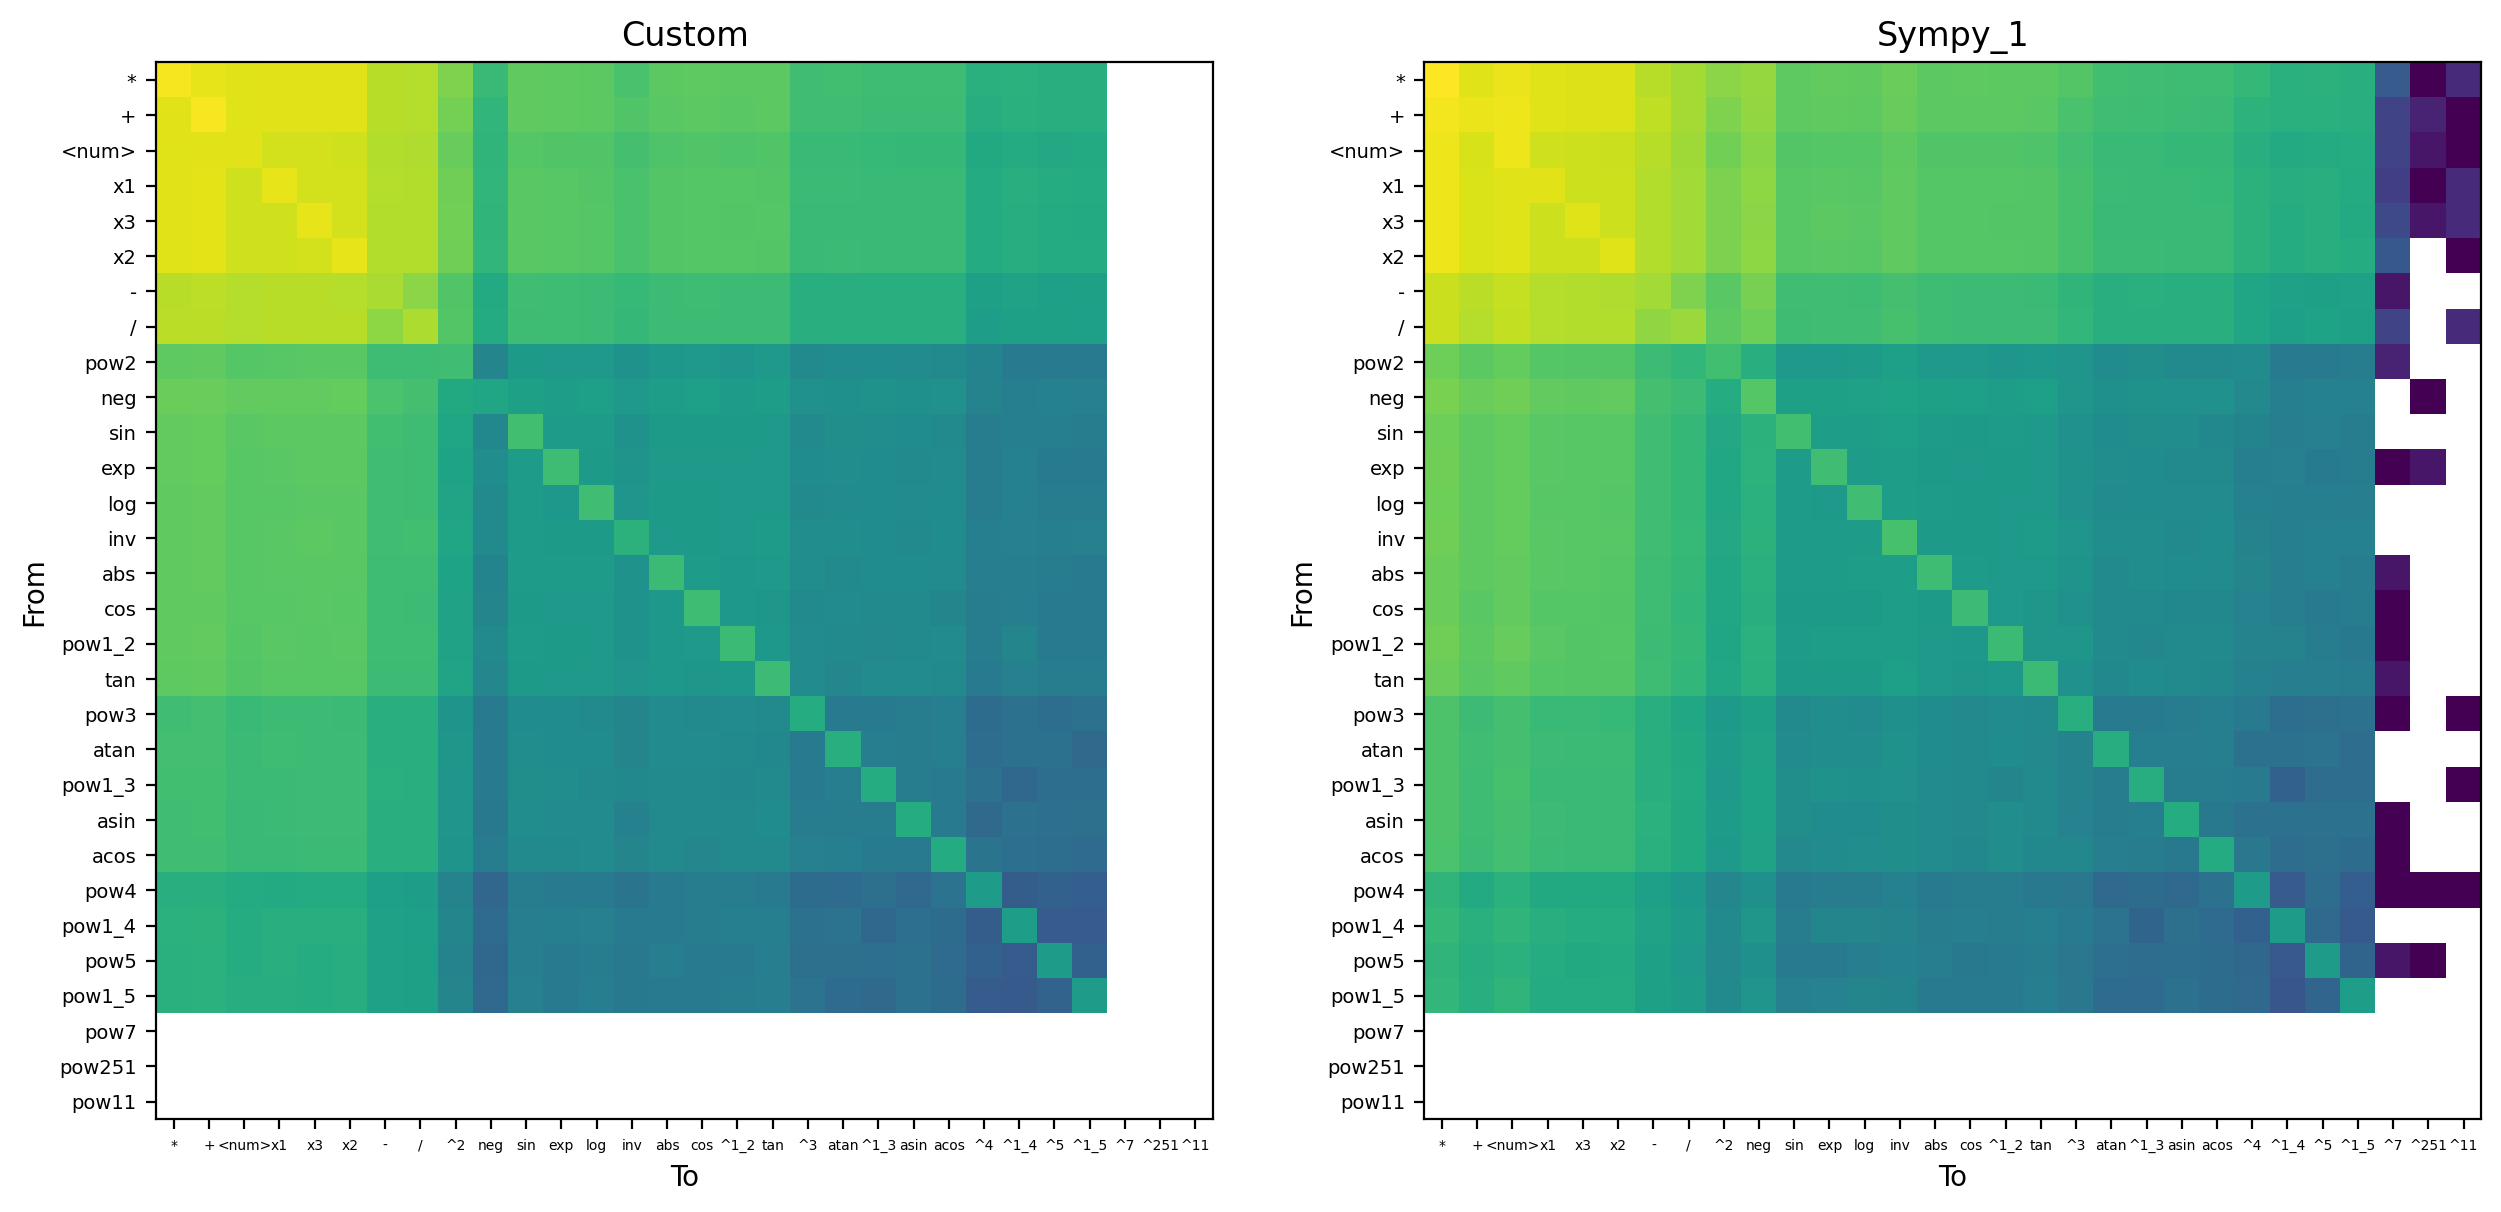

In [27]:
# Show the transition matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 8), dpi=200)

for ax, method in zip(axes, ['custom', 'sympy_1']):
    ax.imshow(transition_matrices[method], cmap='viridis', origin='upper', norm=LogNorm(vmin=1, vmax=max(transition_matrices[m].max() for m in ['custom', 'sympy_1'])))
    ax.set_title(f'{method.capitalize()}')
    ax.set_xticks(np.arange(len(total_counter)))
    ax.set_yticks(np.arange(len(total_counter)))
    ax.set_xticklabels([k.replace('pow', '^') for k, _ in total_counter.most_common()], fontsize=5)
    ax.set_yticklabels([k for k, _ in total_counter.most_common()], fontsize=7)
    ax.set_xlabel('To')
    ax.set_ylabel('From')

Text(0, 0.5, 'From')

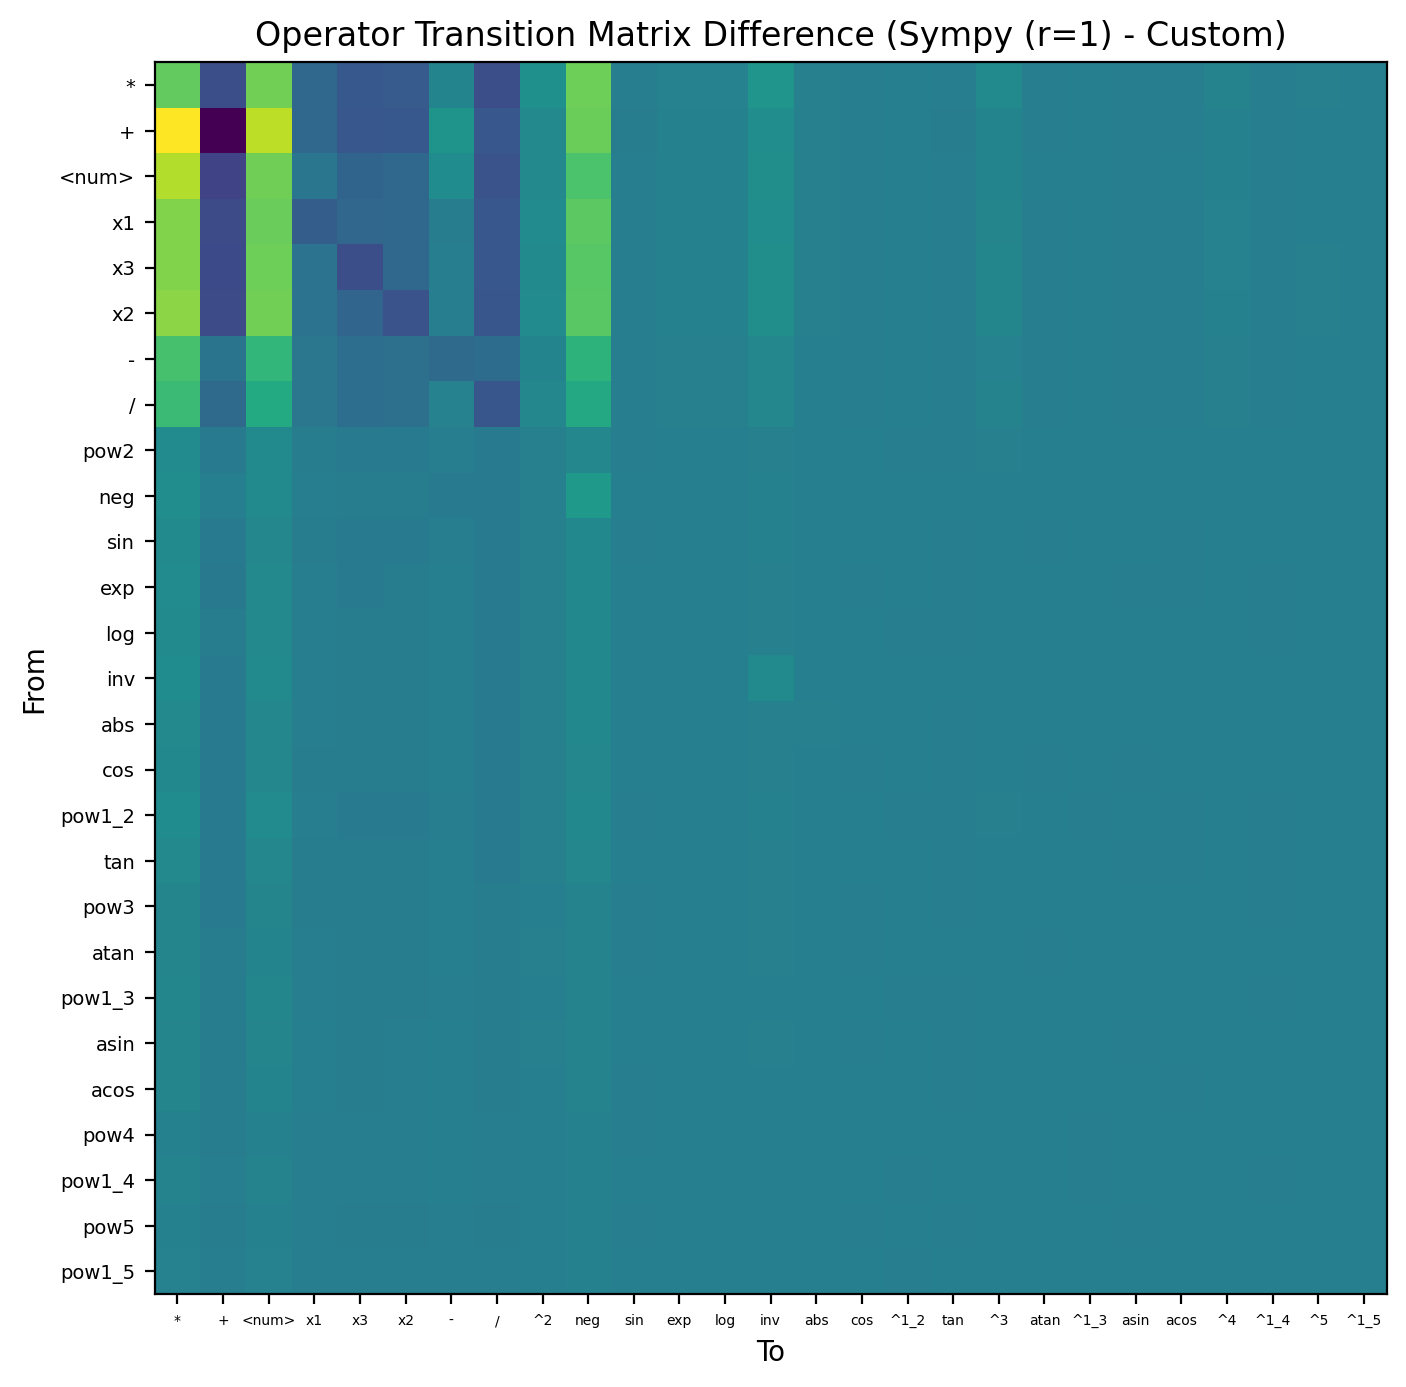

In [28]:
# Show the transition matrices
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=200)

ax.imshow((transition_matrices['sympy_1'] - transition_matrices['custom'])[:27, :27], cmap='viridis', origin='upper')
ax.set_title(f'Operator Transition Matrix Difference (Sympy (r=1) - Custom)')
ax.set_xticks(np.arange(27))
ax.set_yticks(np.arange(27))
ax.set_xticklabels([k.replace('pow', '^') for k, _ in total_counter.most_common()][:27], fontsize=5)
ax.set_yticklabels([k for k, _ in total_counter.most_common()][:27], fontsize=7)
ax.set_xlabel('To')
ax.set_ylabel('From')

# n-Grams

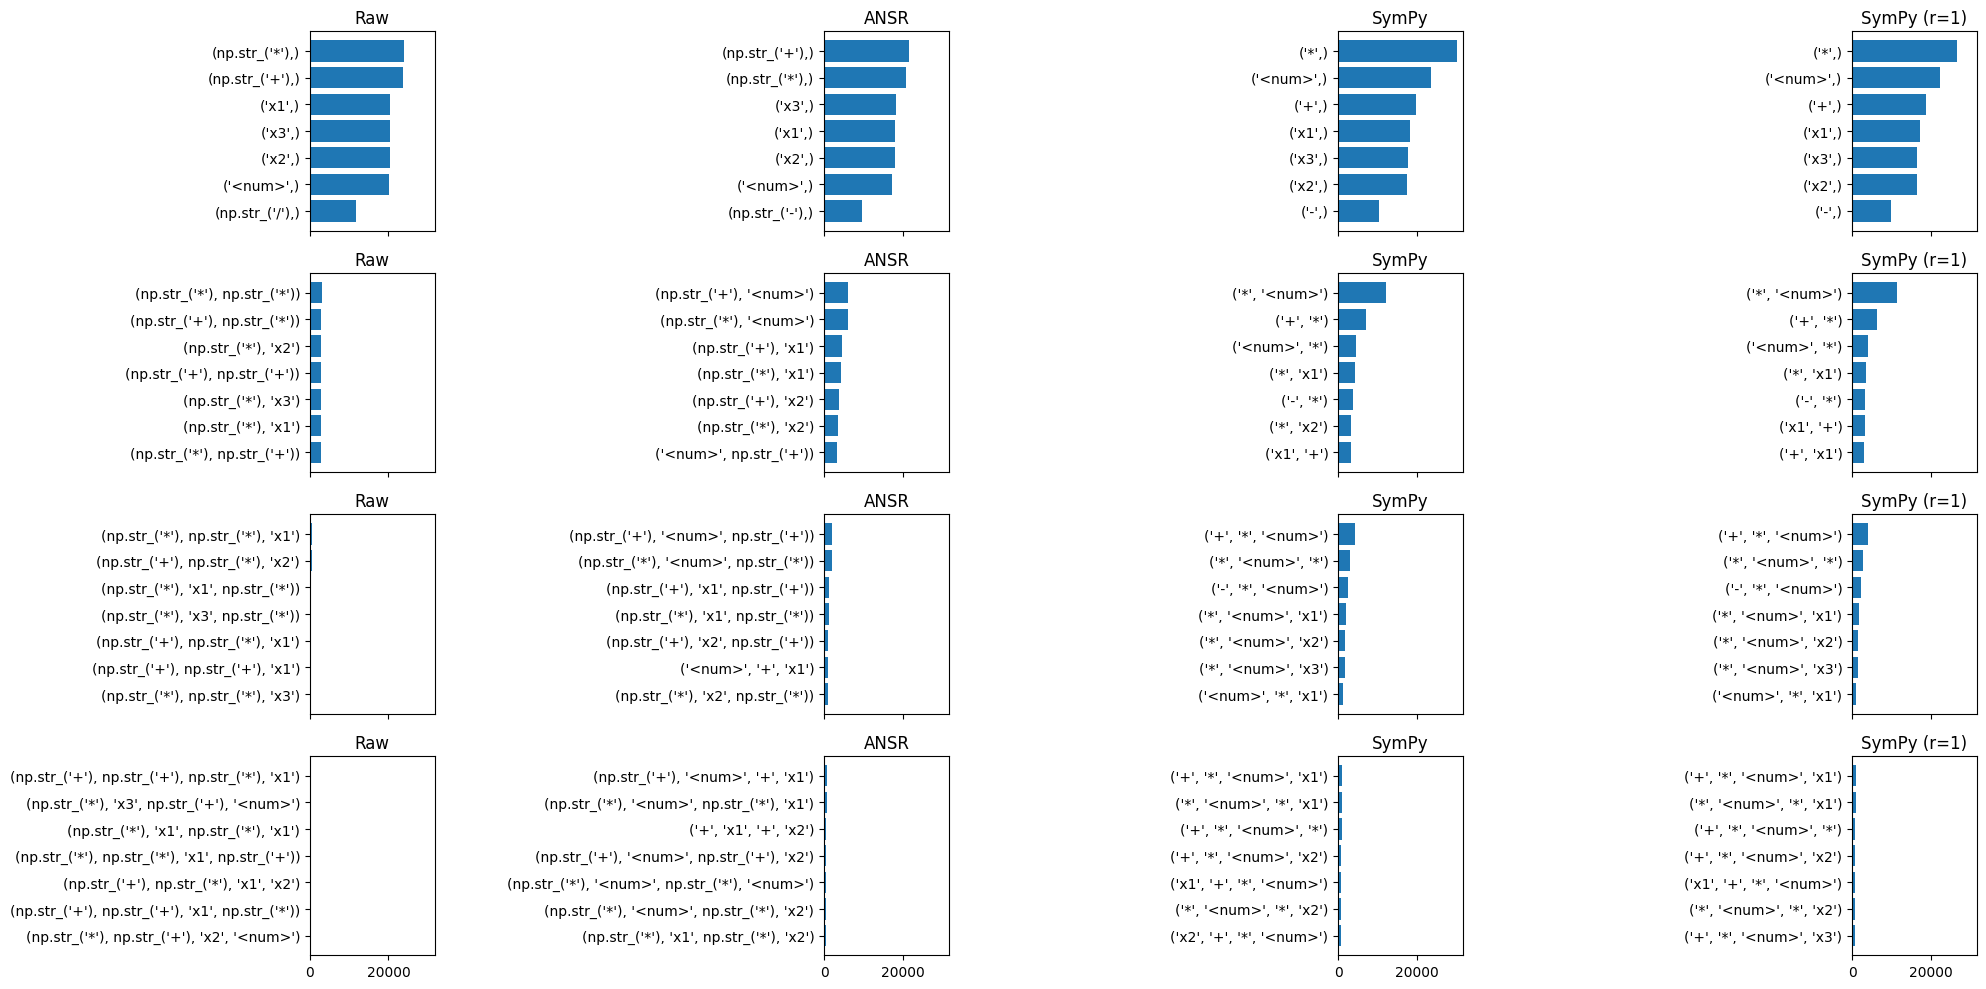

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharex=True)

# Plot the top 5 n-grams for each n and each simplified version (or raw)
for i, key in enumerate(ngrams.keys()):
    for j, n in enumerate(ngrams[key].keys()):
        ngram = [str(a) for a in list(ngrams[key][n].keys())[:7]][::-1]
        count = list(ngrams[key][n].values())[:7][::-1]
        axes[j, i].barh(ngram, count)
        axes[j, i].set_title(f'{method_alias[key]}')

fig.tight_layout(w_pad=5)

# Duplicates & Canonicalization

In [30]:
from flash_ansr.expressions.utils import codify
import warnings
from itertools import permutations
import pandas as pd
from collections import Counter

In [31]:
random_C = np.random.uniform(-10, 10, (128, 100))
random_X = np.random.uniform(-10, 10, (128, 3))

In [32]:
# HACK
def remove_pow1(expression: list[str]):
    filtered_expression = []
    for token in expression:
        if token == 'pow1':
            continue
        
        if token == 'pow_1':
            filtered_expression.append('inv')
            continue

        filtered_expression.append(token)

    return filtered_expression

In [33]:
def get_signatures(skeleton, C, X):
    no_constant_expression = pool.expression_space.remove_num(skeleton)
    executable_prefix_expression = pool.expression_space.operators_to_realizations(no_constant_expression)
    prefix_expression_with_constants, constants = num_to_constants(executable_prefix_expression)
    code_string = pool.expression_space.prefix_to_infix(prefix_expression_with_constants, realization=True)
    code = codify(code_string, pool.expression_space.variables + constants)

    f = pool.expression_space.code_to_lambda(code)
    
    images = []

    if len(constants) == 0:
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            images.append(f(*X.T).round(4))
        except OverflowError:
            pass
    
    else:
        X_with_constants = np.concatenate([X, C[:, :len(constants)]], axis=1)

        warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            images.append(f(*X_with_constants.T).round(4))
        except OverflowError:
            pass

    for image in images:
        image[np.isnan(image)] = 0
    
    return images

In [34]:
signatures = {}

pbar = tqdm(simplified_skeletons.keys())

for raw_skeleton in pbar:
    if len(raw_skeleton) > 10:
        continue
    signatures[raw_skeleton] = {'raw': get_signatures(raw_skeleton, random_C, random_X)}

    for method in ['custom', 'sympy', 'sympy_1']:
        if simplified_skeletons[raw_skeleton][method] is None:
            signatures[raw_skeleton][method] = None
            continue

        filtered_skeleton = remove_pow1(simplified_skeletons[raw_skeleton][method])

        n_constants = len([t for t in filtered_skeleton if t == "<num>"])

        pbar.set_postfix_str(f'Raw: {raw_skeleton}, Simplified: {filtered_skeleton}, Method: {method}, Constants: {n_constants}, Permutations: {len(list(permutations(range(n_constants))))}')

        try:
            signatures[raw_skeleton][method] = get_signatures(filtered_skeleton, random_C, random_X)
        except NameError:
            signatures[raw_skeleton][method] = None

100%|██████████| 10000/10000 [00:01<00:00, 5059.60it/s, Raw: (np.str_('pow1_3'), np.str_('sin'), np.str_('-'), np.str_('neg'), np.str_('-'), np.str_('inv'), '<num>', np.str_('exp'), 'x3', '<num>'), Simplified: ['pow1_3', 'sin', '-', 'neg', '-', 'inv', '<num>', 'exp', 'x3', '<num>'], Method: sympy_1, Constants: 2, Permutations: 2]                                                         


In [35]:
for k in ['custom', 'sympy', 'sympy_1']:
    print(f'Unique skeletons for {k:<7}: {len(set([tuple(s[k]) for s in simplified_skeletons.values() if s[k] is not None and len(s[k]) < 10]))}')

Unique skeletons for custom : 1486
Unique skeletons for sympy  : 1277
Unique skeletons for sympy_1: 1307


In [36]:
for k in ['raw', 'custom', 'sympy', 'sympy_1']:
    print(f'Unique signatures for {k:<7}: {len(set([tuple(s[k][0]) for s in signatures.values() if s[k] is not None]))}')

Unique signatures for raw    : 1048
Unique signatures for custom : 1024
Unique signatures for sympy  : 1019
Unique signatures for sympy_1: 1013


In [37]:
# Count the number of representations for each signature (and for each method)
representation_counts = {k: {} for k in ['raw', 'custom', 'sympy', 'sympy_1']}

for k in ['raw', 'custom', 'sympy', 'sympy_1']:
    for s in signatures.values():
        if s[k] is None:
            continue
        signature = tuple(s[k][0])
        if signature not in representation_counts[k]:
            representation_counts[k][signature] = 0
        representation_counts[k][signature] += 1

# Count the number of unique representations for each method
unique_representation_counts = {k: len(representation_counts[k]) for k in ['raw', 'custom', 'sympy', 'sympy_1']}

In [38]:
for k in ['raw', 'custom', 'sympy', 'sympy_1']:
    print(f'{k:<7}: {Counter(representation_counts[k].values())}')

raw    : Counter({1: 966, 2: 45, 3: 13, 4: 9, 6: 4, 8: 2, 5: 2, 7: 2, 9: 1, 20: 1, 18: 1, 14: 1, 36: 1})
custom : Counter({1: 941, 2: 47, 3: 11, 4: 11, 7: 4, 5: 3, 9: 1, 25: 1, 17: 1, 20: 1, 8: 1, 52: 1, 6: 1})
sympy  : Counter({1: 933, 2: 48, 3: 17, 4: 9, 5: 2, 9: 2, 7: 2, 20: 1, 35: 1, 10: 1, 21: 1, 37: 1, 11: 1})
sympy_1: Counter({1: 925, 2: 49, 3: 19, 4: 6, 5: 2, 6: 2, 12: 2, 10: 1, 17: 1, 32: 1, 38: 1, 11: 1, 19: 1, 8: 1, 7: 1})


In [39]:
raw_signatures = {k: tuple(s['raw'][0]) for k, s in signatures.items() if s['raw'] is not None}
len(raw_signatures)

1292

In [40]:
n_occurrences = {
    k: {
        method: sum(tuple(signatures[k][method][0]) == v for v in raw_signatures.values()) if signatures[k][method] is not None else 0
        for method in ['raw', 'custom', 'sympy', 'sympy_1']}
    for k in tqdm(raw_signatures.keys())
}

100%|██████████| 1292/1292 [00:18<00:00, 68.91it/s]


In [41]:
occurrences_df = pd.DataFrame(n_occurrences.values())

In [42]:
occurrences_df.head(10)

,raw,custom,sympy,sympy_1
0,1,1,1,1
1,1,1,1,1
2,9,9,3,9
3,1,1,1,1
4,1,1,0,0
5,1,1,1,1
6,1,0,0,0
7,1,1,1,1
8,1,1,0,0
9,1,1,1,1


In [43]:
i = 7
print(list(raw_signatures.keys())[i])
print(pool.expression_space.prefix_to_infix(list(raw_signatures.keys())[i]))
print()
for k, v in simplified_skeletons[list(raw_signatures.keys())[i]].items():
    print(k)
    print(v)
    print(pool.expression_space.prefix_to_infix(v))
    print(pool.expression_space.prefix_to_infix(pool.expression_space.remove_num(v)))
    print()

(np.str_('*'), np.str_('-'), 'x3', 'x1', 'x2')
(x3 - x1) * x2

custom
[np.str_('*'), 'x2', np.str_('-'), 'x3', 'x1']
x2 * (x3 - x1)
x2 * (x3 - x1)

sympy
('*', 'x2', '+', 'neg', 'x1', 'x3')
x2 * (neg(x1) + x3)
x2 * (neg(x1) + x3)

sympy_1
('*', 'x2', '+', 'neg', 'x1', 'x3')
x2 * (neg(x1) + x3)
x2 * (neg(x1) + x3)



In [44]:
i = 8
print(list(raw_signatures.keys())[i])
print(pool.expression_space.prefix_to_infix(list(raw_signatures.keys())[i]))
print()
for k, v in simplified_skeletons[list(raw_signatures.keys())[i]].items():
    print(k)
    print(v)
    print(pool.expression_space.prefix_to_infix(v))
    print(pool.expression_space.prefix_to_infix(pool.expression_space.remove_num(v)))
    print()

(np.str_('sin'), np.str_('pow3'), np.str_('*'), np.str_('-'), np.str_('*'), 'x3', 'x1', np.str_('exp'), 'x3', 'x3')
sin(pow3(((x3 * x1) - exp(x3)) * x3))

custom
[np.str_('sin'), np.str_('pow3'), np.str_('*'), 'x3', np.str_('-'), np.str_('*'), 'x1', 'x3', np.str_('exp'), 'x3']
sin(pow3(x3 * ((x1 * x3) - exp(x3))))
sin(pow3(x3 * ((x1 * x3) - exp(x3))))

sympy
('sin', '*', 'pow3', 'x3', 'pow3', '-', '*', 'x1', 'x3', 'exp', 'x3')
sin(pow3(x3) * pow3((x1 * x3) - exp(x3)))
sin(pow3(x3) * pow3((x1 * x3) - exp(x3)))

sympy_1
('sin', '*', 'pow3', 'x3', 'pow3', '-', '*', 'x1', 'x3', 'exp', 'x3')
sin(pow3(x3) * pow3((x1 * x3) - exp(x3)))
sin(pow3(x3) * pow3((x1 * x3) - exp(x3)))



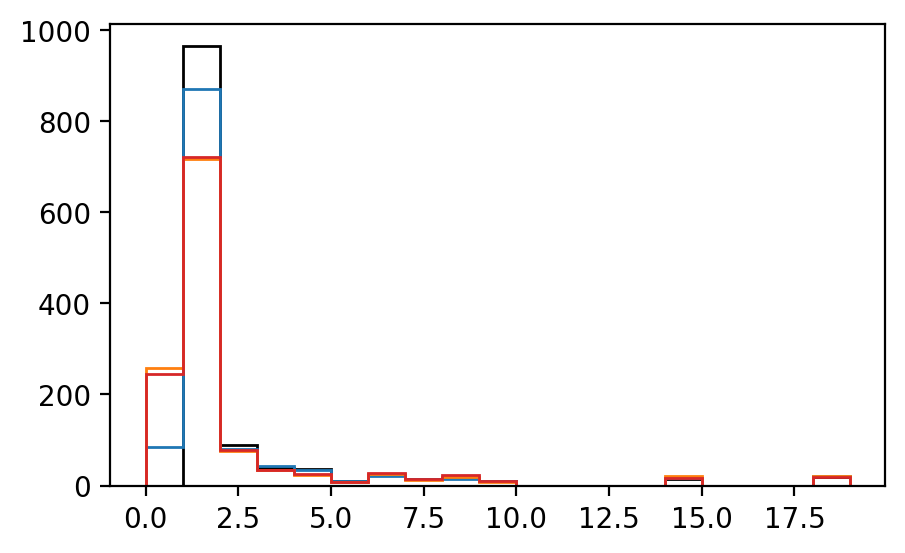

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

ax.hist(occurrences_df['raw'], bins=np.arange(0, 20), label='Raw', color='k', histtype='step');
ax.hist(occurrences_df['custom'], bins=np.arange(0, 20), label='Custom', color='tab:blue', histtype='step');
ax.hist(occurrences_df['sympy'], bins=np.arange(0, 20), label='SymPy', color='tab:orange', histtype='step');
ax.hist(occurrences_df['sympy_1'], bins=np.arange(0, 20), label='SymPy (r=1)', color='tab:red', histtype='step');